<h1  style="text-align: center" >1. Importing Necessary Libraries</h1><a id = "1"></a>

In [1]:
# для работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

import warnings
warnings.filterwarnings('ignore')

# для препроцессинга данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# для построения модели
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback

<h1  style="text-align: center" >2. Load Data</h1><a id = "2"></a>

<h1>About Dataset</h1>

This file contains data on top 50 bestselling novels on Amazon each year from 2009 to 2021. The data is collected from amazon.com website and Kaggle. The inspiration behind it was Greywasp's Top 50 Bestselling Novels 2009-2020 of Amazon. The CSV Format of both zipped & unzipped are in this format.

In [2]:
a1 = os.path.basename("Amazon Top 50 Books 2009-2021 - Reworked Sheet (1).csv")
b1 = os.path.abspath("Amazon Top 50 Books 2009-2021 - Reworked Sheet (1).csv").replace(a, '')
df1 = pd.read_csv(b1 +"\\" + a1, sep=',')

a2 = os.path.basename("Amazon Top 50 Books 2009-2021 - Reworked Sheet (2).csv")
b2 = os.path.abspath("Amazon Top 50 Books 2009-2021 - Reworked Sheet (2).csv").replace(a, '')
df2 = pd.read_csv(b2 +"\\" + a2, sep=',')

df = pd.concat([df1,df2], ignore_index=True)
df.head()

,Name,Author,User Rating,Reviews,Price,Price_r,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,"17,350",$8.00,$8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,"2,052",$22.00,$22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,"18,979",$15.00,$15,2018,Non Fiction
3,1984,George Orwell,4.7,"70,425",$7.48,$8,2021,Fiction
4,1984 (Signet Classics),George Orwell,4.7,"21,424",$6.00,$6,2017,Fiction


In [3]:
print(f"Shape of dataset ---> {df.shape}")

Shape of dataset ---> (1300, 8)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1300 non-null   object 
 1   Author       1300 non-null   object 
 2   User Rating  1300 non-null   float64
 3   Reviews      1300 non-null   object 
 4   Price        1300 non-null   object 
 5   Price_r      1300 non-null   object 
 6   Year         1300 non-null   int64  
 7   Genre        1300 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 81.4+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
User Rating,1300.0,4.635385,0.221431,3.3,4.5,4.7,4.8,4.9
Year,1300.0,2015.000000,3.743097,2009.0,2012.0,2015.0,2018.0,2021.0


In [6]:
df.describe(include='O').T

,count,unique,top,freq
Name,1300,420,Publication Manual of the American Psychologic...,20
Author,1300,292,Jeff Kinney,28
Reviews,1300,886,8580,10
Price,1300,87,$8.00,112
Price_r,1300,82,$8,60
Genre,1300,2,Non Fiction,726


<h2>Basic summary</h2>

Данные содержат 1300 наблюдений и 8 столбцов. В датасете представлены наименование произведения, его автор, рейтинг, количество оценивающих людей, цена за книгу на Amazon, округленная цена за книгу, год, когда книга попала в список бестселлеров и жанр(fiction, non-fiction).

Столбцы <b>Rewiews</b> и <b>Price</b> представлены типом object из-за запятых и знака $ соответственно. Вероятно, столбец <b>Price_r</b> не нужен в данном анализе.

In [7]:
df['Price'] = df.Price.str.replace('$','').astype(np.float64)

In [8]:
df['Reviews'] = df['Reviews'].replace(',','', regex=True)

In [9]:
# меняем тип объекта на int64
df['Reviews'] = df['Reviews'].astype(np.int64)

In [10]:
# удаляем лишнее
df = df.drop('Price_r', axis=1)

In [11]:
#теперь можно посмотреть на результат снова
df.describe().T

,count,mean,std,min,25%,50%,75%,max
User Rating,1300.0,4.635385,0.221431,3.3,4.5,4.7,4.8,4.9
Reviews,1300.0,17204.853846,20707.675353,37.0,4786.0,9957.0,22383.0,193482.0
Price,1300.0,12.764169,10.172474,0.0,7.0,11.0,15.0,105.0
Year,1300.0,2015.000000,3.743097,2009.0,2012.0,2015.0,2018.0,2021.0


<h2>Basic summary</h2>

Теперь можно заметить, что есть книги с ценой 0 (вероятно, выбросы или отсутствие данных). Количество оценивающих пользователей в рамках от 37 до 193 тысяч, из-за чего с.к.о довольно велик. В дальнейшем понадобится изменить масштабирование для построения модели.

In [12]:
#аналих данных
df.groupby('Year')['Price', 'Reviews', 'User Rating'].agg({'User Rating':['count','mean'],
                                                           'Reviews':'mean',
                                                           'Price':'mean'})

User Rating          Reviews    Price
           count   mean      mean     mean
Year                                      
2009         100  4.584   4710.12  15.4000
2010         100  4.558   5479.62  13.4800
2011         100  4.558   8100.82  15.1000
2012         100  4.532  13090.92  15.3000
2013         100  4.554  13098.14  14.6000
2014         100  4.622  15859.94  14.6400
2015         100  4.648  14233.38  10.4200
2016         100  4.678  14196.00  13.1800
2017         100  4.660  12888.40  11.3800
2018         100  4.668  13930.42  10.5200
2019         100  4.740  15898.34  10.0800
2020         100  4.726  35814.66  10.9400
2021         100  4.732  56362.34  10.8942

<h2> Basic summary</h2>

Можно заметить, что в среднем, оценка литературных произведений возрастает, аналогично, количество оценивающих пользователей. Однако средняя цена книги в каждом году падает. 

In [13]:
# самые дорогие писатели (топ-5) на Amazon
df.groupby('Author')['Price'].agg(['max']).sort_values('max', ascending=False).head()

,max
Author,
American Psychiatric Association,105.0
Stephenie Meyer,82.0
Lin-Manuel Miranda,54.0
Bill Simmons,53.0
J. K. Rowling,52.0


In [14]:
# топ 5 книг с высоким рейтингом на Amazon
df.groupby(['Author','Name'])['User Rating'].agg(['max']).sort_values('max', ascending=False).head()

max
Author                Name                                                   
Emily Winfield Martin The Wonderful Things You Will Be                    4.9
Barack Obama          A Promised Land                                     4.9
Bill Martin Jr.       Brown Bear, Brown Bear, What Do You See?            4.9
                      Chicka Chicka Boom Boom                             4.9
J.K. Rowling          Harry Potter and the Sorcerer's Stone: The Illu...  4.9

In [15]:
#топ 5 самый плодовитых писателей на Amazon
df.groupby(['Author'])['Name'].agg(['nunique']).sort_values('nunique', ascending=False).head()

,nunique
Author,
Jeff Kinney,14
Rick Riordan,10
Stephenie Meyer,8
Dav Pilkey,8
J.K. Rowling,6


<h1  style="text-align: center" >3. Missing Values And Outliers</h1><a id = "3"></a>

In [16]:
# проверка нулевых значений
df.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

In [17]:
# уникальные значения по столбцам
df.nunique()

Name           420
Author         292
User Rating     14
Reviews        443
Price           87
Year            13
Genre            2
dtype: int64

In [18]:
num_col = df.select_dtypes(include=np.number)
cat_col = df.select_dtypes(exclude=np.number)

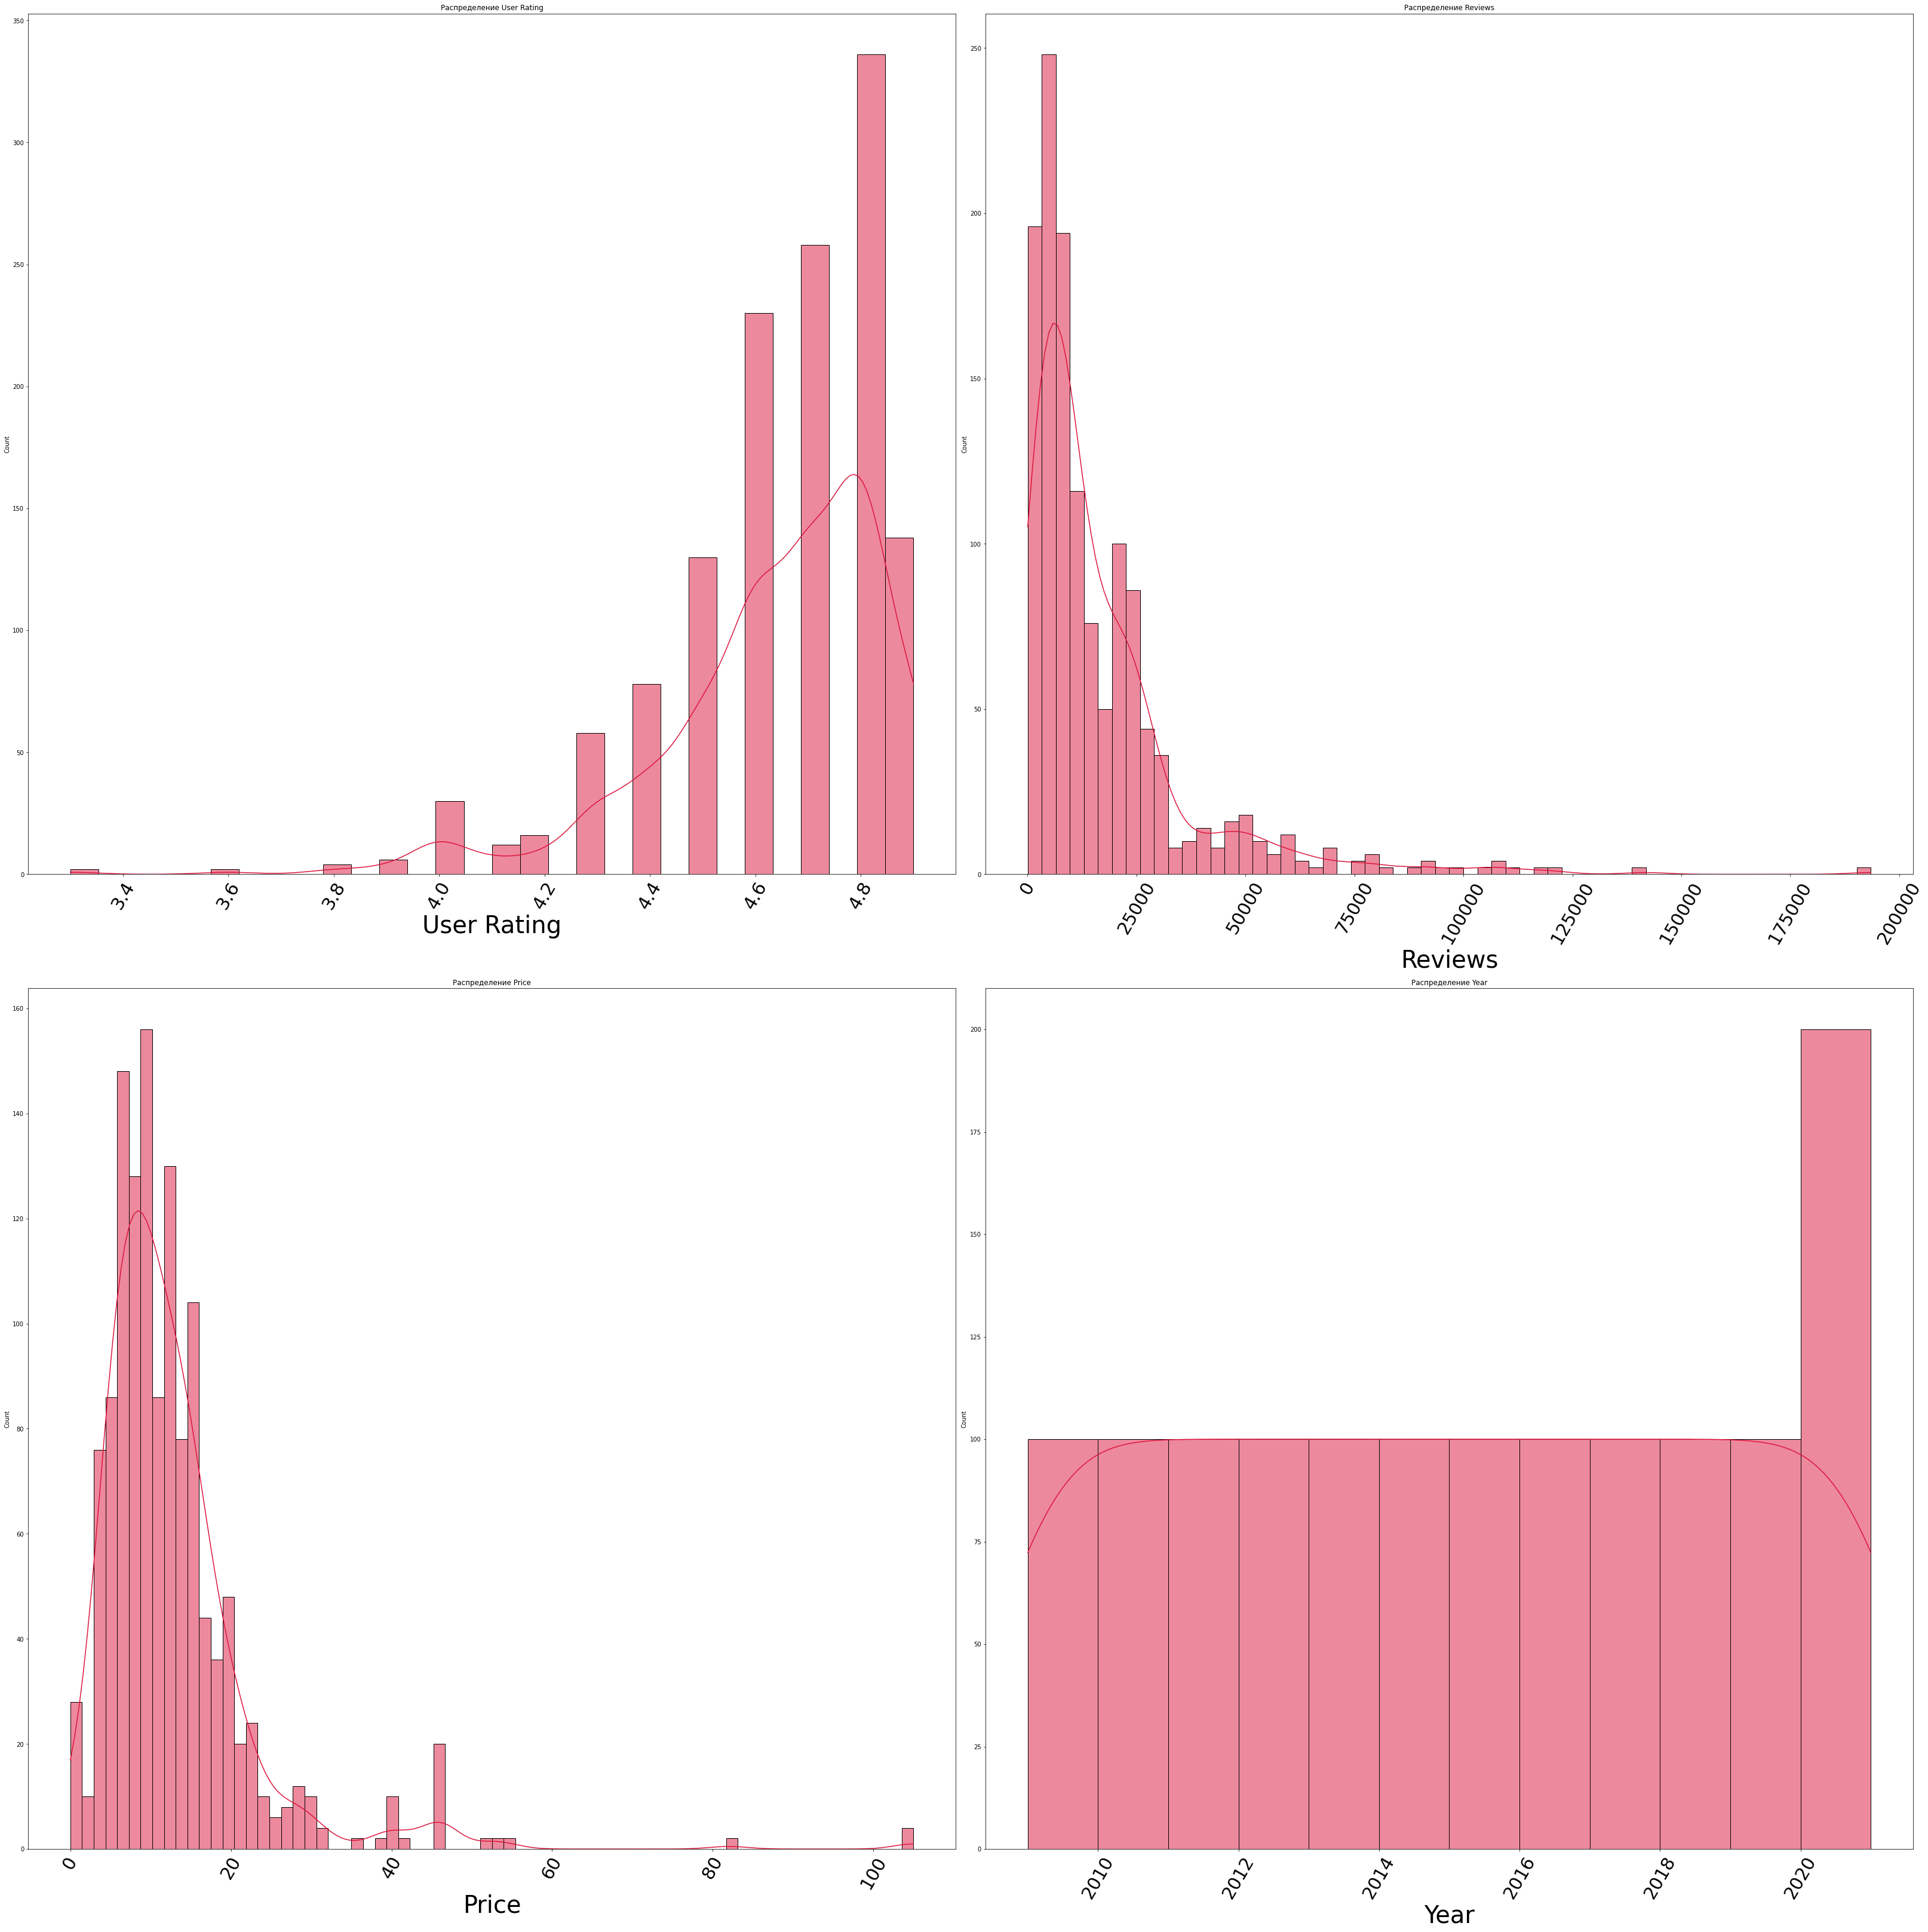

In [19]:
plt.figure(figsize=(45,45))
for index, column in enumerate(num_col):
    plt.subplot(2,2,index+1)
    plt.title(f"Распределение {column}")
    sns.histplot(data=num_col, x=column, kde=True, color='crimson')
    plt.xticks(rotation = 60, fontsize=30)
    plt.xlabel(column,fontsize=40)
plt.tight_layout(pad=1.0)
plt.show()

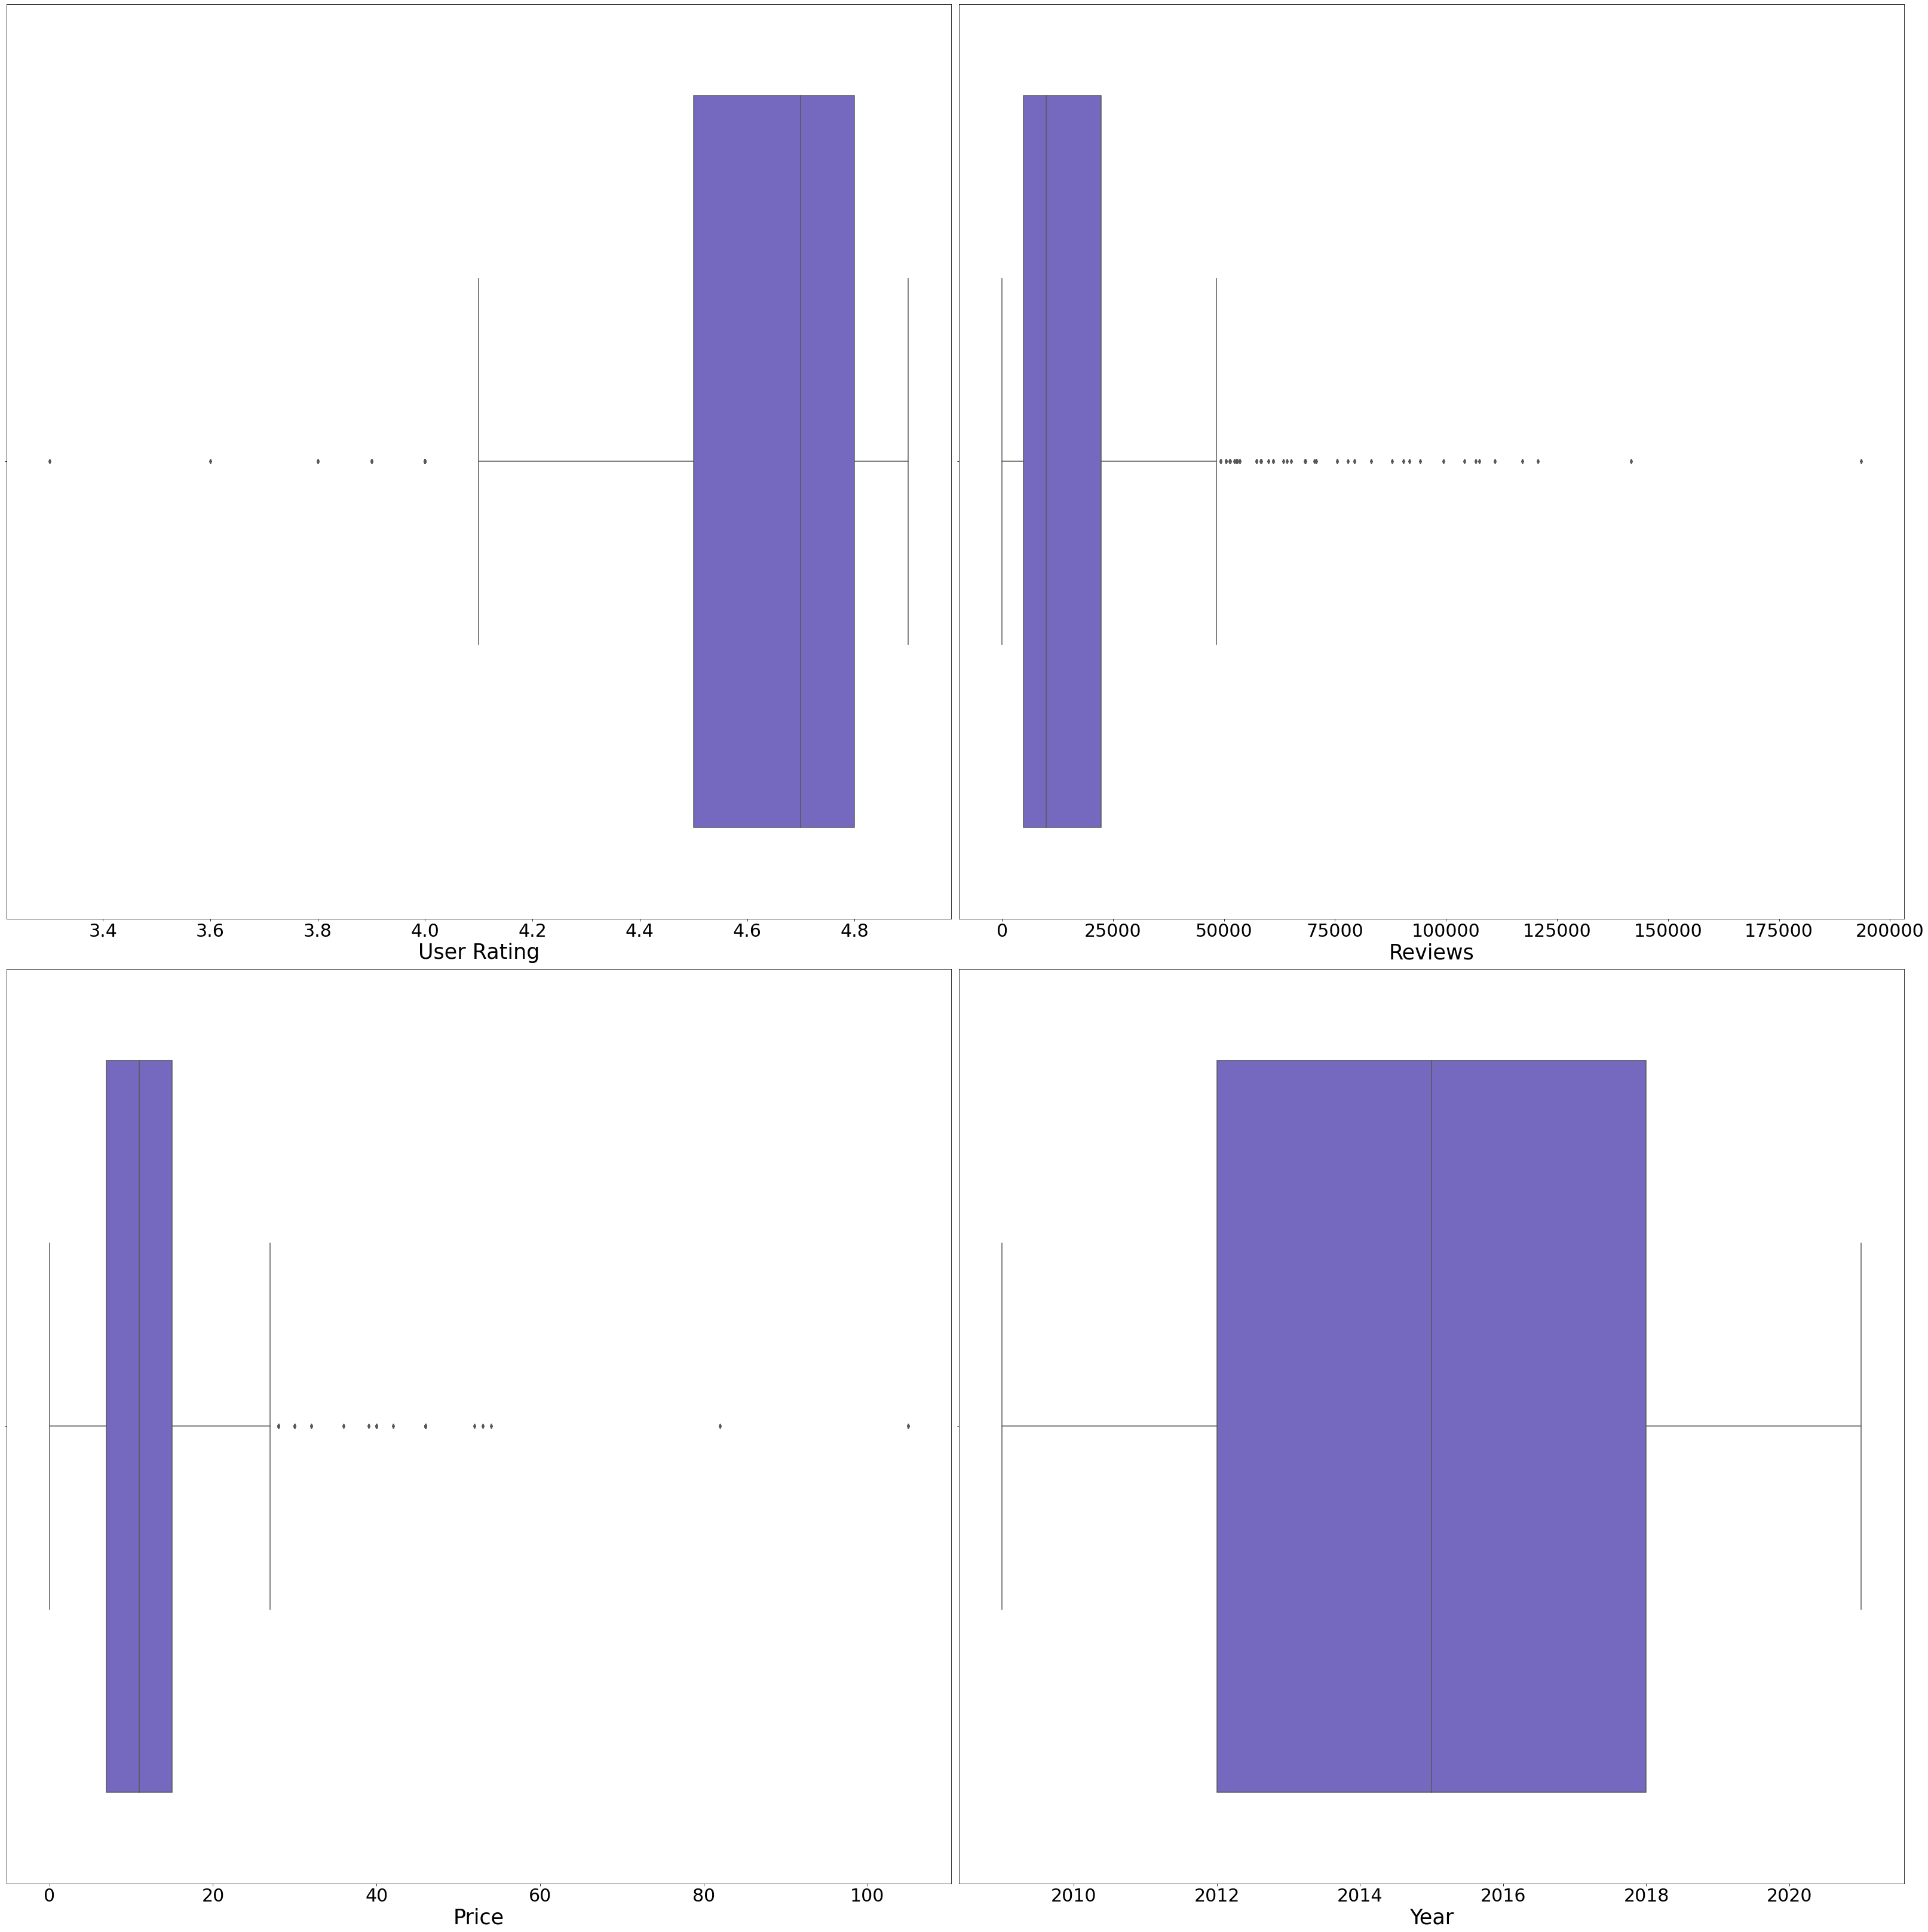

In [20]:
plt.figure(figsize=(45,45))
for index, column in enumerate(num_col):
    plt.subplot(2,2,index+1)
    sns.boxplot(data=num_col, x=column, color='slateblue')
    plt.xticks(fontsize=30)
    plt.xlabel(column, fontsize=35)

plt.tight_layout(pad=1.0)
plt.show()

<h2> Basic summary</h2>

<b>User Rating</b> не имеет нормально распределение, поэтому мы лографмируем переменную.
Также - у всех переменных, кроме <b>Year</b>, замечены выбросы, которые будут убраны далее.

In [21]:
df['User Rating'] = df['User Rating'].apply(lambda x: math.log(x))

In [22]:
def del_outliers(data_col, df):
    """
    Функция для удаления выбросов, выходящих за пределы (среднее +- 3*с.к.о.)
    data_col - столбец данных
    df - dataframe
    """
    mean, std = df[data_col].mean(), df[data_col].std()
    cut = std * 3
    lower, upper = mean - cut, mean + cut
    new_df = df[(df[data_col] < upper) & (df[data_col] > lower)]
    return new_df

In [23]:
#убираем выбросы
df = del_outliers('User Rating', df)
df = del_outliers('Reviews', df)
df = del_outliers('Price', df)

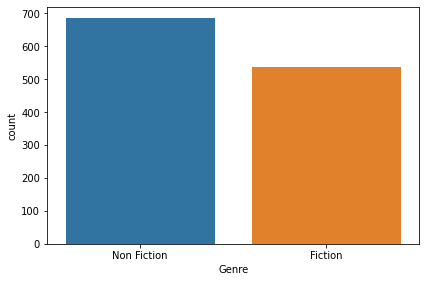

In [24]:
sns.countplot(data=df,x='Genre')
plt.tight_layout(pad = 1.0)
plt.show()

<h2> Basic summary</h2>

<b>Genre</b> не имеет сильного смещения в пользу одной из категорий.

<AxesSubplot:>

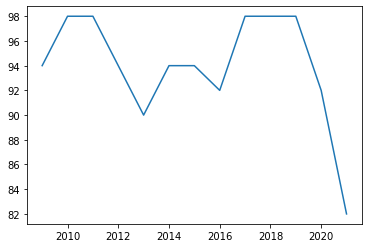

In [25]:
df['Year'].value_counts().sort_index().plot.line()

In [26]:
#считаем дисперсию 
df.var()

User Rating    1.965742e-03
Reviews        2.144186e+08
Price          4.622168e+01
Year           1.382741e+01
dtype: float64

<h2> Basic summary</h2>

Дисперсия переменных не имеет существенных отклонений, поэтому все переменные остаются. 

<h1  style="text-align: center" > 4. Multivariative Data Analysis </h1> <a id=4> </a>

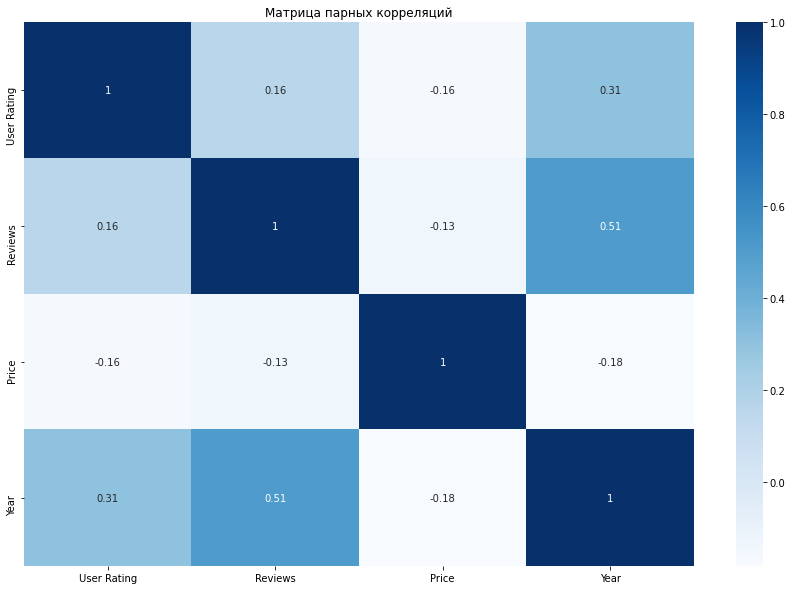

In [27]:
#оценим корреляцию показателей
plt.figure(figsize=(15,10))
plt.title("Матрица парных корреляций")
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

<h1>Basic Summary</h1>

Корреляция выше 0.6 между данными не была замечена (проблемы мультиколлинеарности в данных нет). Значит, данные переменные можно использовать в модели далее. 

<Figure size 1080x1080 with 0 Axes>

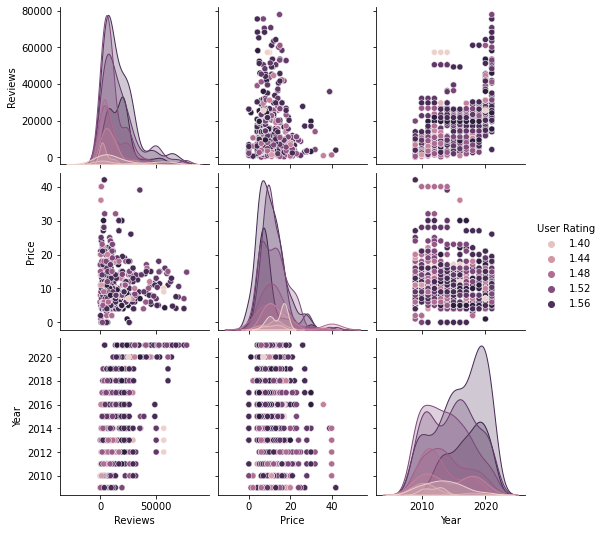

In [28]:
plt.figure(figsize=(15,15))
ax = sns.pairplot(df, hue='User Rating')
plt.show()

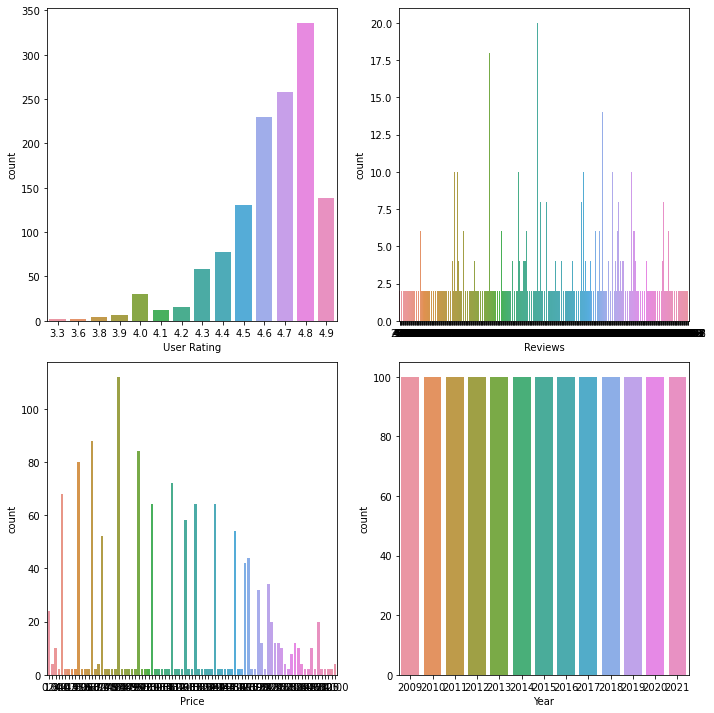

In [29]:
#финальное построение графиков распределения
plt.figure(figsize=(10,10))
for index, column in enumerate(num_col):
    plt.subplot(2,2,index+1)
    sns.countplot(data=num_col, x=column)
    
plt.tight_layout(pad = 1.0)
plt.show()

<h1 style="text-align: center" >5. Data Preprocessing </h1><a id = "5"></a>

In [30]:
df_preprocessed = df.copy()

In [31]:
cat_col.nunique()

Name      420
Author    292
Genre       2
dtype: int64

In [32]:
le = LabelEncoder()
for i in ['Author','Name','Genre']:
    df_preprocessed[i] = le.fit_transform(df_preprocessed[i])
df_preprocessed.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,0,129,1.547563,17350,8.00,2016,1
1,1,247,1.526056,2052,22.00,2011,0
2,2,153,1.547563,18979,15.00,2018,1
3,3,107,1.547563,70425,7.48,2021,0
4,4,107,1.547563,21424,6.00,2017,0


In [33]:
#формируем зависимые переменные x и независимую переменную Y
X = df_preprocessed.drop('User Rating', axis=1)
y = df_preprocessed['User Rating']

In [34]:
#Разделение данных на тестовую и тренировочную подвыборки
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
x_train.shape, x_test.shape

((977, 6), (245, 6))

In [35]:
#преобразование данных через метод StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

<h1 style="text-align: center" >6. Models </h1><a id="6"></a>

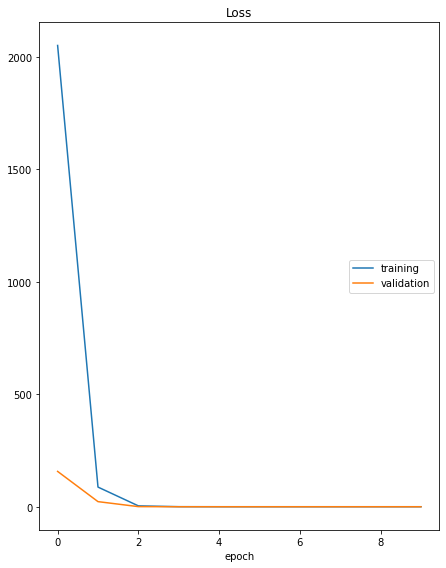

Loss
	training         	 (min:    0.002, max: 2049.996, cur:    0.005)
	validation       	 (min:    0.002, max:  157.037, cur:    0.008)
31/31 - 0s - loss: 0.0053 - val_loss: 0.0081 - 182ms/epoch - 6ms/step


In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, input_shape=(6,)))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MSE

model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2, callbacks=[PlotLossesCallback()])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


<h2> Summary</h2>

Модель показала низкие результаты средней квадратической ошибки на валидационной выборке, что говорит о качестве построенной модели.